In [110]:
FILE_PATH = 'dataset/PUBG.csv'

column_prefix = {
    "solo": "solo_",
    "duo": "duo_",
    "squad": "squad_"
}

headers = {
    "solo": {
        "per_game_target": [
            'solo_KillDeathRatio',
            'solo_WinRatio',
            'solo_WinTop10Ratio',
            'solo_Top10Ratio',
        ],
        "per_game_columns": [
            'solo_DamagePg',
            'solo_HeadshotKillsPg',
            'solo_HealsPg',
            'solo_KillsPg',
            'solo_MoveDistancePg',
            # 'solo_RevivesPg', # 솔로 매치는 부활 불가능
            'solo_RoadKillsPg',
            'solo_TeamKillsPg',
            'solo_TimeSurvivedPg',
            'solo_Top10sPg'
        ]
    },
    "duo": {
        "per_game_target": [
            'duo_KillDeathRatio',
            'duo_WinRatio',
            'duo_WinTop10Ratio',
            'duo_Top10Ratio',
        ],
        "per_game_columns": [
            'duo_DamagePg',
            'duo_HeadshotKillsPg',
            'duo_HealsPg',
            'duo_KillsPg',
            'duo_MoveDistancePg',
            'duo_RevivesPg',
            'duo_RoadKillsPg',
            'duo_TeamKillsPg',
            'duo_TimeSurvivedPg',
            'duo_Top10sPg'
        ]
    },
    "squad": {
        "per_game_target": [
            'squad_KillDeathRatio',
            'squad_WinRatio',
            'squad_WinTop10Ratio',
            'squad_Top10Ratio',
        ],
        "per_game_columns": [
            'squad_DamagePg',
            'squad_HeadshotKillsPg',
            'squad_HealsPg',
            'squad_KillsPg',
            'squad_MoveDistancePg',
            'squad_RevivesPg',
            'squad_RoadKillsPg',
            'squad_TeamKillsPg',
            'squad_TimeSurvivedPg',
            'squad_Top10sPg'
        ]
    }
}

import pandas as pd

def load_dataset(match_type):
    df = pd.read_csv(FILE_PATH)
    print(f"{FILE_PATH} successfully loadded")

    all_col_names = df.columns.tolist()
    col_names = list(filter(lambda x: x.startswith(column_prefix[match_type]), all_col_names))

    return df.loc[:, df.columns.isin(col_names)]

MATCH_TYPE = 'solo'
# MATCH_TYPE = 'duo'
# MATCH_TYPE = 'squad'

CORR_METHOD = 'pearson'

per_game_columns = headers[MATCH_TYPE]["per_game_columns"]
all_game_columns = headers[MATCH_TYPE]["per_game_columns"]
all_game_columns.append('solo_WinRatio')

In [188]:
from sklearn.neural_network import MLPRegressor
df = load_dataset(MATCH_TYPE)

from sklearn.model_selection import train_test_split
data = df[all_game_columns].values

from sklearn.preprocessing import MinMaxScaler
scaled_data = MinMaxScaler().fit(data).transform(data)

x = scaled_data[:, :9]
y = scaled_data[:, 9:]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=1)

dataset/PUBG.csv successfully loadded


In [189]:
regr = MLPRegressor(
    hidden_layer_sizes=(100, 160, 80),
    activation='relu',
    solver='lbfgs',
    learning_rate_init=0.00001,
    max_iter=20000,
    random_state=1
).fit(x_train, y_train)

/Users/kina/Documents/GitHub/PUBG-Statistic/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [190]:
import pandas as pd

y_pred_pd = pd.DataFrame(regr.predict(x_test), columns = ['pred_winRatio'])
y_pred_pd['index'] = y_pred_pd.index

In [191]:
y_test_pd = pd.DataFrame(y_test, columns = ['real_winRatio'])
y_test_pd['index'] = y_test_pd.index

In [192]:
y_result_pd = pd.merge(y_pred_pd, y_test_pd, on='index')
y_result_pd = y_result_pd.sort_values(by=['real_winRatio', 'pred_winRatio'])
y_result_pd = y_result_pd.drop(columns = ['index'])
y_result_pd = y_result_pd.reset_index(drop=True)
y_result_pd['index'] = y_result_pd.index
y_result_pd

,pred_winRatio,real_winRatio,index
0,-0.213770,0.0,0
1,-0.182520,0.0,1
2,-0.179998,0.0,2
3,-0.167452,0.0,3
4,-0.166010,0.0,4
...,...,...,...
26365,1.005866,1.0,26365
26366,1.018819,1.0,26366
26367,1.019355,1.0,26367
26368,1.065394,1.0,26368


<AxesSubplot:xlabel='index', ylabel='pred_winRatio'>

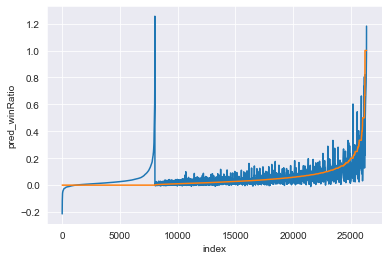

In [193]:
import seaborn as sns

sns.lineplot(data=y_result_pd, x="index", y="pred_winRatio")
sns.lineplot(data=y_result_pd, x="index", y="real_winRatio")

In [194]:
score = regr.score(x_test, y_test)
print("score:", score)

score: 0.6040391410593472
